In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import bluepysnap as bp

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from cinplaAnalysis.utils import *
from cinplaAnalysis.icsd import StandardCSD

In [4]:
path_to_simulation = '../hippocampusSim/'

# Load LFP Signals

In [5]:


s = bp.Simulation(path_to_simulation+'simulation_config_big.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    for iteration in range(numIter):
        p = pd.read_pickle('../hippocampusSim/pkls_big/eeg_'+t+'_'+str(iteration)+'.pkl')
        if iteration == 0:
            s = p
        else:
            s += p
        
    signals.append(s)

totalSignal = 0
for s in signals:
    totalSignal += s

In [6]:


s = bp.Simulation(path_to_simulation+'simulation_config_small.json') # Loads simulation object
nodes = s.circuit.nodes

population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

types = np.sort(list(s.circuit.nodes.property_values('mtype')))

signals_small = []
for t in types[:-1]:
    
    typeIds = nodes.ids(group=t).get_ids()
    numIter = int(np.ceil(len(typeIds)/10000))

    p = pd.read_pickle('../hippocampusSim/pkls/eeg_'+t+'.pkl')
        
    signals_small.append(p)

totalSignal_small = 0
for s in signals_small:
    totalSignal_small += s

In [7]:
totalSignal -= np.mean(totalSignal.loc[1000:10000],axis=0)
totalSignal_small -= np.mean(totalSignal_small.loc[1000:10000],axis=0)

# Computes Fourier Transform

In [8]:
from numpy.fft import fft, fftfreq

In [9]:
s = totalSignal[6].loc[10000:]
s -= np.mean(s)
fourier = fft(s)
f = fftfreq(len(s),d=0.001)

s = totalSignal_small[6].loc[10000:]
s -= np.mean(s)
fourier_small = fft(s)
f_small = fftfreq(len(s),d=0.001)

In [12]:
np.abs(fourier)

array([8.18954504e-09, 6.25490758e-03, 5.20078981e-03, ...,
       4.22209094e-03, 5.20078981e-03, 6.25490758e-03])

# Defines plotting function

In [13]:
def plotFig(ax,csd,absmax=None,isLeft=True,plotCB=False):

    electrodeDistance = 91.91300234460844

    if absmax is None:
        absmax = np.max(np.abs(csd))/2
    
    im = ax.imshow(np.array(csd), origin='lower', vmin =-absmax,vmax=absmax, cmap='bwr_r', interpolation='gaussian')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax,label='CSD (A/$m^2$)')
        cb.formatter.set_powerlimits((0,0))


    ax.set_xticks([10000,10500,11000],labels=['0','0.5','1'])

    ax.set_xlim([10000,11000])

    ax.set_xlabel('Time (s)')

    if isLeft:
        ax.set_ylabel('Depth ($\mu$m)')
        ax.set_yticks([0,3,6,9],labels=[np.round(electrodeDistance*10),np.round(electrodeDistance*7),np.round(electrodeDistance*4),np.round(electrodeDistance)])
    if not isLeft:
        ax.set_yticklabels([])


In [14]:
numLFP_electrodes = 11

In [15]:
lfpIdx = np.arange(numLFP_electrodes)
totalLFP = totalSignal[lfpIdx]
totalLFP_small = totalSignal_small[lfpIdx]


# Extracts electrode positions

In [16]:
import h5py
file = h5py.File('../electrodeFile/coeffs_big.h5')
electrodePos = []
for e in np.arange(numLFP_electrodes):
    electrodePos.append(file['electrodes'][str(e)]['position'][:])
    
electrodePos = np.array(electrodePos)
file.close()

In [17]:
electrodeDistance = np.linalg.norm(electrodePos[1]-electrodePos[0])

# Removes baseline offset

In [18]:
meanLfp = np.mean(totalLFP,axis=0)
totalLFP -= meanLfp

meanLfpSmall = np.mean(totalLFP_small,axis=0)
totalLFP_small -= meanLfpSmall

# Calculates CSD

In [19]:
lfp_data = totalLFP.values.T * 1E-3 * pq.V        # [mV] -> [V]
lfp_data_small = totalLFP_small.values.T * 1E-3 * pq.V        # [mV] -> [V]


z_data = np.arange(0,numLFP_electrodes) * electrodeDistance * 1e-6 * pq.m

sigma = 0.277 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]


In [20]:
std_input = {
    'lfp' : lfp_data,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

std_input_small = {
    'lfp' : lfp_data_small,
    'coord_electrode' : z_data,
    'sigma' : sigma,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

std_csd = StandardCSD(**std_input)
std_csd_small = StandardCSD(**std_input_small)

csd = std_csd.get_csd()
csd = std_csd.filter_csd(csd)

csdsmall = std_csd_small.get_csd()
csdsmall = std_csd_small.filter_csd(csd)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


# Plots Panels e, f, and g of Figure 7

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


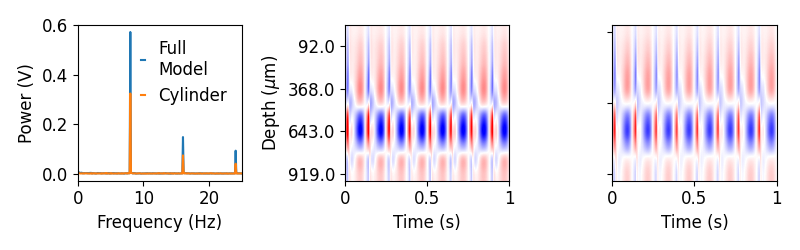

In [24]:
fig, axes = plt.subplots(1,3,figsize=(8,2.5))

axes[0].plot(f[:len(f)//2],np.abs(fourier[:len(f)//2]))
axes[0].plot(f_small[:len(f_small)//2],np.abs(fourier_small[:len(f_small)//2]))
axes[0].set_xlim([0,25])
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power (V)')
axes[0].legend(['Full\nModel','Cylinder'],handlelength=0.25,loc='upper right',framealpha=0)

plotFig(axes[1],csd)
# ax.set_title('iCSD')

csdsmall = std_csd_small.get_csd()
csdsmall = std_csd_small.filter_csd(csd)

plotFig(axes[2],csdsmall,np.max(np.abs(csd))/2,isLeft=False)

plt.tight_layout()
plt.savefig('figures/hippocampus.png',dpi=600)

# Plots colorbar for CSD

/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/gpfs/bbp.cscs.ch/home/tharayil/bluerecording-dev/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


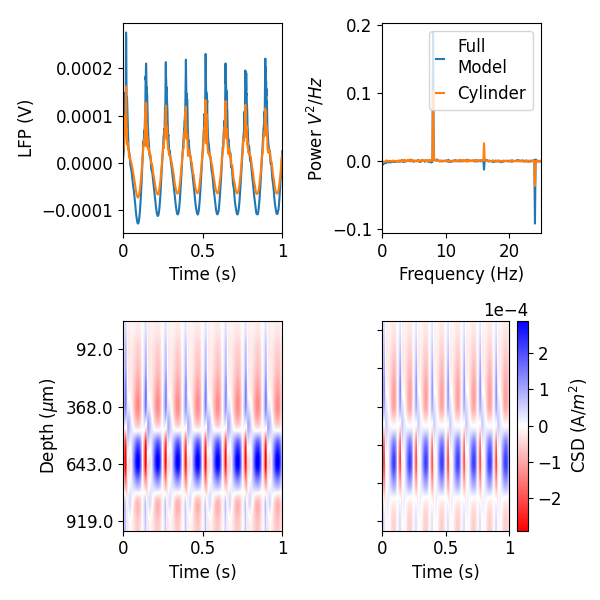

In [25]:
fig, axes = plt.subplots(2,2,figsize=(6,6))

axes[0][0].plot(totalSignal[6])
axes[0][0].plot(totalSignal_small[6])
axes[0][0].set_xlim([10000,11000])
axes[0][0].set_xticks([10000,10500,11000],labels=['0','0.5','1'])
axes[0][0].set_xlabel('Time (s)')
axes[0][0].set_ylabel('LFP (V)')

axes[0][1].plot(f[:len(f)//2],fourier[:len(f)//2])
axes[0][1].plot(f_small[:len(f_small)//2],fourier_small[:len(f_small)//2])
axes[0][1].set_xlim([0,25])
axes[0][1].set_xlabel('Frequency (Hz)')
axes[0][1].set_ylabel('Power $V^2/Hz$')
axes[0][1].legend(['Full\nModel','Cylinder'],handlelength=0.5,loc='upper right')

plotFig(axes[1][0],csd)
# ax.set_title('iCSD')

csdsmall = std_csd_small.get_csd()
csdsmall = std_csd_small.filter_csd(csd)

plotFig(axes[1][1],csdsmall,np.max(np.abs(csd))/2,isLeft=False,plotCB=True)

plt.tight_layout()

plt.savefig('figures/hippocmapus_colorbar.png',dpi=600)

In [26]:
csd.units

array(1.) * A/m**2